In [1]:
import pandas as pd
from torch.utils.data import DataLoader,Dataset, Subset
import numpy as np
import tft_model
from data_formatters import ts_dataset  
import data_formatters.base
import expt_settings.configs
import importlib
from data_formatters import utils
import torch.optim as optim
import torch
from tqdm import tqdm
import pickle
import time

In [2]:
pd.set_option('max_columns', 1000)

In [3]:
importlib.reload(utils)

<module 'data_formatters.utils' from '/home/arda/Desktop/thesis/submodules/Temporal_Fusion_Transform/data_formatters/utils.py'>

In [4]:
ExperimentConfig = expt_settings.configs.ExperimentConfig

config = ExperimentConfig('m5', 'outputs')

with open('data_formatter_m5.pkl', 'rb') as input:
    data_formatter = pickle.load(input)

# data_formatter = config.make_data_formatter()


# print("*** Training from defined parameters for {} ***".format('m4'))
# data_csv_path = '/home/arda/Desktop/thesis/m5_tft_data.csv'
# print("Loading & splitting data...")
# raw_data = pd.read_csv(data_csv_path, index_col=0)
# print(raw_data.shape)
# start = time.time()
# train, valid, test = data_formatter.split_data(raw_data)
# train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
# )
# print(time.time()-start)

# with open('train_m5.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(train, output, pickle.HIGHEST_PROTOCOL)

with open('train_m5.pkl', 'rb') as input:
    train = pickle.load(input)

# with open('valid_m5.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(valid, output, pickle.HIGHEST_PROTOCOL)

# with open('test_m5.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(test, output, pickle.HIGHEST_PROTOCOL)
    
# with open('data_formatter_m5.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(data_formatter, output, pickle.HIGHEST_PROTOCOL)

In [5]:
# Sets up default params
fixed_params = data_formatter.get_experiment_params()
params = data_formatter.get_default_model_params()

fixed_params.update(params)
fixed_params['batch_first'] = True
fixed_params['name'] = 'test'
fixed_params['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fixed_params['minibatch_size'] = 256
# fixed_params['category_count'] = [6]
device = fixed_params['device']

# with open('data_formatter_m4.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(data_formatter, output, pickle.HIGHEST_PROTOCOL)


In [6]:
max_samples = 256 * 500 * 2
# elect = ts_dataset.TSDataset(fixed_params, max_samples, train)

# with open('ts_dataset_m5.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(elect, output, pickle.HIGHEST_PROTOCOL)

with open('ts_dataset_m5.pkl', 'rb') as input:
    elect = pickle.load(input)

In [7]:
loader = DataLoader(
            elect,
            batch_size=fixed_params['minibatch_size'],
            num_workers=2,
            shuffle=True
        )

In [8]:
fixed_params

{'total_time_steps': 224,
 'num_encoder_steps': 196,
 'num_epochs': 100,
 'early_stopping_patience': 5,
 'multiprocessing_workers': 5,
 'column_definition': [('id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>),
  ('date', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>),
  ('quantity', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>),
  ('sell_price', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>),
  ('wday', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>),
  ('month', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>),
  ('year', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>),
  ('store_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>),
  ('item_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>),
  ('dept_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>),
  ('cat_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>),
  ('state_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>)],
 'input_size'

In [9]:
importlib.reload(tft_model)
# fixed_params['device'] = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device='cpu'

model = tft_model.TFT(fixed_params).to(device)
# for batch in loader:
#         batch['inputs'][batch['inputs'] !=batch['inputs']] = 0
#         output, all_inputs, attention_components = model(batch['inputs'])
#         break

{'total_time_steps': 224, 'num_encoder_steps': 196, 'num_epochs': 100, 'early_stopping_patience': 5, 'multiprocessing_workers': 5, 'column_definition': [('id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('date', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('quantity', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('sell_price', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('wday', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>), ('month', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>), ('year', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>), ('store_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>), ('item_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>), ('dept_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>), ('cat_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>), ('state_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>)], 'input_size': 10, 'output_size': 1, 'cat

In [10]:
q_loss_func = tft_model.QuantileLoss([0.5])
# import sys
# sys.path.append('/home/arda/Desktop/thesis/')
# from loss_modules import PinballLoss
# q_loss_func = PinballLoss(0.45, device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
model.train()
epochs=150
losses = []
for i in range(epochs):
    epoch_loss = [] 
    progress_bar = tqdm(enumerate(loader), total=len(loader))
    for batch_num, batch in progress_bar:
        batch['inputs'][batch['inputs'] !=batch['inputs']] = 0
        optimizer.zero_grad()
        output, all_inputs, attention_components = model(batch['inputs'])
        loss= q_loss_func(output[:,:,:].view(-1,1), batch['outputs'][:,:,0].flatten().float().to(device))
#         loss= q_loss_func(output[:,:,:].squeeze(2), batch['outputs'][:,:,0].float().to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), fixed_params['max_gradient_norm'])
        optimizer.step()
        epoch_loss.append(loss.item())
    
    losses.append(np.mean(epoch_loss))
    if loss.item() <= min(losses):
        torch.save(model.state_dict(), 'm5_best_model_smape_loss.pth')
        
    print(np.mean(epoch_loss))
    

100%|██████████| 1000/1000 [07:58<00:00,  2.09it/s]

0.1354744697585702



100%|██████████| 1000/1000 [07:55<00:00,  2.10it/s]

0.1269960747435689



100%|██████████| 1000/1000 [07:49<00:00,  2.13it/s]

0.12528943549841642



100%|██████████| 1000/1000 [07:51<00:00,  2.12it/s]

0.12508956698328258



100%|██████████| 1000/1000 [07:58<00:00,  2.09it/s]

0.12449816234409809



 94%|█████████▍| 939/1000 [07:20<00:29,  2.08it/s]

KeyboardInterrupt: 

9


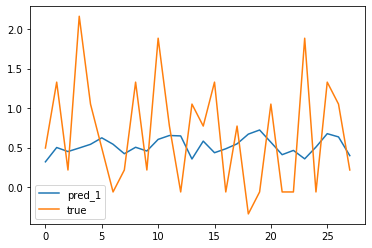

In [29]:
import matplotlib.pyplot as plt
import numpy as np

ind = np.random.choice(64)
print(ind)
plt.plot(output[ind,:,0].detach().cpu().numpy(), label='pred_1')
# plt.plot(output[ind,:,1].detach().cpu().numpy(), label='pred_5')
# plt.plot(output[ind,:,2].detach().cpu().numpy(), label='pred_9')

plt.plot(batch['outputs'][ind,:,0], label='true')
plt.legend()

In [19]:
output[ind,:,0].detach().cpu().numpy()

array([-0.3465522 , -0.3337534 , -0.34024906, -0.34141082, -0.34037155,
       -0.3295918 , -0.34068084, -0.33649057, -0.34301734, -0.34508902,
       -0.33977687, -0.33765274, -0.34118813, -0.3378281 , -0.34688747,
       -0.34193462, -0.33781588, -0.34457272, -0.34175783, -0.34381402,
       -0.3391223 , -0.33760005, -0.3363303 , -0.3425253 , -0.34272957,
       -0.34181   , -0.33680505, -0.33977598], dtype=float32)